In [1]:
from autoML import AutoML
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [2]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [4]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
67,Parkki,170.0,19.0,20.7,23.2,9.3960,3.4104
137,Pike,500.0,42.0,45.0,48.0,6.9600,4.8960
87,Perch,120.0,20.0,22.0,23.5,5.6400,3.5250
107,Perch,300.0,26.9,28.7,30.1,7.5852,4.6354
81,Perch,85.0,18.2,20.0,21.0,5.0820,2.7720


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [5]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,407.695276,26.378740,28.548031,31.381102,8.958450,4.396091
std,376.316126,10.414029,11.175092,12.101264,4.373456,1.707593
min,0.000000,10.000000,10.500000,11.600000,1.728400,1.148400
25%,120.000000,19.000000,20.850000,22.500000,5.830250,3.363600
50%,273.000000,25.200000,27.300000,29.200000,7.680000,4.234000
75%,685.000000,33.850000,36.450000,40.550000,12.367400,5.789550
max,1650.000000,59.000000,63.400000,68.000000,18.754200,7.595800


In [6]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

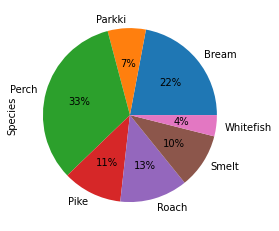

In [7]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

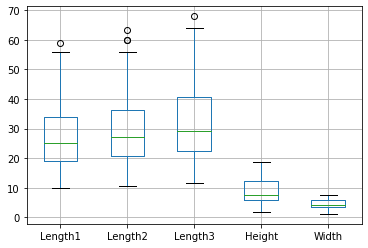

In [8]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [9]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    # our regressors
    "autoML": AutoML(fitting_time=30),
}

## Check training performance

In [10]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [11]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [12]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,603.282335,2.486840,-0.115933,0.000652,0.002319
1,decisionTree,55.324831,0.060627,0.972791,0.003989,0.002464
2,linearRegression,94.527649,0.128784,0.944607,0.021960,0.003046
3,randomForestRegressor,39.607190,0.029844,0.986617,0.090588,0.007805
4,autoML,41.820260,0.031426,0.986389,30.172975,0.008291


### Preprocessing - One-hot encoding "Species"

In [13]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
67,170.0,19.0,20.7,23.2,9.3960,3.4104,0,1,0,0,0,0,0
137,500.0,42.0,45.0,48.0,6.9600,4.8960,0,0,0,1,0,0,0
87,120.0,20.0,22.0,23.5,5.6400,3.5250,0,0,1,0,0,0,0
107,300.0,26.9,28.7,30.1,7.5852,4.6354,0,0,1,0,0,0,0
81,85.0,18.2,20.0,21.0,5.0820,2.7720,0,0,1,0,0,0,0


In [14]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,599.937303,2.666192,-0.206880,0.001053,0.001493
1,decisionTree,51.621938,0.044024,0.979690,0.002504,0.002230
2,linearRegression,68.195912,0.057817,0.972966,0.001955,0.002199
3,randomForestRegressor,41.060831,0.031175,0.986214,0.092952,0.008127
4,autoML,40.697959,0.029609,0.987013,30.194913,0.008242


### Preprocessing - One-hot encoding + standardization

In [15]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,599.062303,2.472411,-0.030323,0.000708,0.001335
1,decisionTree,52.515262,0.046238,0.978229,0.002733,0.002065
2,linearRegression,68.195912,0.057817,0.972966,0.001896,0.002181
3,randomForestRegressor,40.478725,0.029954,0.986904,0.094171,0.008151
4,autoML,47.061084,0.044087,0.980646,30.178824,0.007279


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [16]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [17]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,611.121082,7.547395,0.150468,0.000030,0.000029
1,decisionTree,50.184375,0.066154,0.969656,0.002045,0.001393
2,linearRegression,92.812927,0.223035,0.900731,0.004544,0.001185
3,randomForestRegressor,31.847187,0.026972,0.986484,0.103606,0.007434
4,autoML,31.928704,0.027897,0.986067,30.218619,0.007882
